# Unsupervised Segmentation of DAPI dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import torch
import genus as gn
import numpy
from genus.util_data import  DataloaderWithLoad, ConditionalRandomCrop, DatasetInMemory
from genus.util import linear_interpolation, append_to_dict, ckpt2file, load_yaml_as_dict, load_obj
from genus.util_vis import show_batch
from genus.model import CompositionalVae, instantiate_optimizer, instantiate_scheduler, process_one_epoch
from functools import partial
import torchvision
from torchvision import transforms

In [4]:
config_file = "./config_VQVAE.yaml"
config = load_yaml_as_dict(config_file)
BATCH_SIZE = config["simulation"]["BATCH_SIZE"]

In [5]:
# We transform them to tensors
transform = transforms.ToTensor()

train_data = torchvision.datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

# Load and transform data
train_data = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)


train_dataset = DatasetInMemory(x=train_data.data.unsqueeze(-3).float()/(255.0),
                                y=train_data.targets,
                                store_in_cuda=False)
test_dataset = DatasetInMemory(x=test_data.data.unsqueeze(-3).float()/(255.0),
                               y=test_data.targets,
                               store_in_cuda=False)

BATCH_SIZE = 512
test_loader = DataloaderWithLoad(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader = DataloaderWithLoad(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Create the dataloader as usual

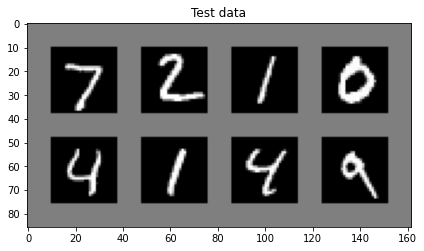

In [6]:
img, _, _ = test_loader.load(index=torch.tensor([0,1,2,3,4,5,6,7]))
show_batch(img, title="Test data",  pad_value=0.5, n_padding=10)

In [7]:
config_file = "./config_VQVAE.yaml"
config = load_yaml_as_dict(config_file)

In [8]:

x = torch.zeros((3,1,28,28))
x1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1)(x)
x2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)(x1)
x3 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)(x2)


y1 = torch.nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1)(x3)
y2 = torch.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1)(y1)
y3 = torch.nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)(y2)
            

print(x1.shape)
print(x2.shape)
print(x3.shape)

print(y1.shape)
print(y2.shape)
print(y3.shape)

torch.Size([3, 16, 14, 14])
torch.Size([3, 32, 7, 7])
torch.Size([3, 32, 7, 7])
torch.Size([3, 32, 14, 14])
torch.Size([3, 16, 28, 28])
torch.Size([3, 1, 28, 28])


In [33]:
from typing import NamedTuple, Optional
from torch.nn import functional as F


from genus.encoders_decoders import EncoderConv, DecoderConv
from genus.namedtuple import Output, MetricMiniBatch
    
class ZZ(NamedTuple):
    z: torch.Tensor
    zq: torch.Tensor
    index: torch.Tensor
    
class NewEncoderConv(torch.nn.Module):
    def __init__(self, size: int, ch_in: int, dim_z: int):
        super().__init__()
        self.ch_in = ch_in
        self.width = size
        self.dim_z = dim_z
        assert size==28

       # self.conv = torch.nn.Sequential(
       #     torch.nn.Conv2d(in_channels=self.ch_in, out_channels=16, kernel_size=4, stride=2, padding=1),  # 16,16
       #     torch.nn.ReLU(inplace=True),
       #     torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1),  # 8,8
       #     torch.nn.ReLU(inplace=True),
       #     torch.nn.Conv2d(in_channels=32, out_channels=self.dim_z, kernel_size=4, stride=2, padding=1),  # 4,4
       # )
        
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=self.ch_in, out_channels=16, kernel_size=3, stride=2, padding=1),  # 14,14
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),  # 7,7
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=32, out_channels=self.dim_z, kernel_size=3, stride=1, padding=1),  # 7,7
        )

    def forward(self, x: torch.Tensor):
        return self.conv(x)
    
class NewDecoderConv(torch.nn.Module):
    def __init__(self, size: int, ch_out: int, dim_z: int):
        super().__init__()
        self.ch_out = ch_out
        self.width = size
        self.dim_z = dim_z
        assert size==28
        
        #self.upconv = torch.nn.Sequential(
        #    torch.nn.ConvTranspose2d(in_channels=self.dim_z, out_channels=32, kernel_size=4, stride=2, padding=1),  # 8,8
        #    torch.nn.ReLU(inplace=True),
        #    torch.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),  # 16,16
        #    torch.nn.ReLU(inplace=True),
        #    torch.nn.ConvTranspose2d(in_channels=16, out_channels=self.ch_out, kernel_size=4, stride=2, padding=1),  # 32,32
        #)
        
        self.upconv = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=self.dim_z, out_channels=32, kernel_size=4, stride=2, padding=1),  # 14,14
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),  # 28,28
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(in_channels=16, out_channels=self.ch_out, kernel_size=3, stride=1, padding=1),  # 28,28
        )
        
    def forward(self, z: torch.Tensor):
        return self.upconv(z)
    
class Quantizer(torch.nn.Module):
    def __init__(self, n_word: int, dim: int):
        super().__init__()
        self.dim = dim
        self.n_word = n_word
        self.embedding = torch.nn.Parameter(data=torch.randn((dim, n_word), dtype=torch.float), requires_grad=True)
        
    def forward(self, x):
        z = x.flatten(end_dim=-2)  # shape = (*, dim)
        
        # dist(z,y)=||z-y||^2 = z^2 + y^2 - 2*z*y
        with torch.no_grad():
            z2 = z.pow(2).sum(dim=-1, keepdim=True)              # shape = (*, 1)
            y2 = self.embedding.pow(2).sum(dim=-2, keepdim=True) # shape = (1, n_word)
            yz = torch.matmul(z, self.embedding)                 # shape = (*, n_word)
            embed_indices = (z2 + y2 - 2 * yz).min(dim=-1)[1]    # shape = (*)
            iq = embed_indices.view_as(x[...,0]).unsqueeze(-1)

        zq = F.embedding(embed_indices, self.embedding.transpose(0, 1)) # shape = (*, dim)
        xq = zq.view_as(x) 
        loss_commitment = (xq.detach() - x).pow(2).mean()  # force encoder close to chosen code
        loss_codebook = (xq - x.detach()).pow(2).mean()    # force codes close to encoder values
        
        return x + (xq-x).detach(), iq, loss_codebook, loss_commitment
        
    
    

class VQVAE(torch.nn.Module):
    def __init__(self, ch_img: int, word_size: int, dictionary_size: int) -> None:
        super().__init__()
        self.vq_beta = 0.25
        self.dim_z = word_size
        self.dictionary_size = dictionary_size
        self.ch_img = ch_img
        self.encoder = NewEncoderConv(size=28, ch_in=self.ch_img, dim_z=self.dim_z)
        self.decoder = NewDecoderConv(size=28, ch_out=self.ch_img, dim_z=self.dim_z)
        self.quantizer = Quantizer(n_word=self.dictionary_size, dim=self.dim_z)
        
        if torch.cuda.is_available():
            self.cuda()
    
    
    def forward(self, imgs_in, 
                iom_threshold=None, 
                noisy_sampling=None, 
                draw_image=False,
                draw_bg=False,
                draw_boxes=False,
                draw_boxes_ideal=False,
                verbose=False):
        
        z = self.encoder(imgs_in) # B, dim_z, w, h
        hq, iq, loss_codebook, loss_commitment = self.quantizer(z.permute(0,2,3,1))
        zq = hq.permute(0,3,1,2)
        index_q = iq.permute(0,3,1,2)
        
        imgs_out = self.decoder(zq) 
        rec = ((imgs_in-imgs_out)/0.1).pow(2).mean()
        loss = rec + loss_codebook + 0.25 * loss_commitment
        
        return Output(metrics=MetricMiniBatch(loss=loss,
                                              mse_av=rec,
                                              loss_codebook=loss_codebook,
                                              loss_commitment=loss_commitment,
                                              count_prediction=-1*numpy.ones(1),
                                              wrong_examples=-1*numpy.ones(1),
                                              accuracy=-1.0),
                      inference=ZZ(z=z, zq=zq, index=index_q), 
                      imgs=imgs_out, 
                      bb_imgs=imgs_in)
        
        
vae = VQVAE(ch_img=1, word_size=16, dictionary_size=256)

if torch.cuda.is_available():
    img = img.cuda()
    
a = vae(img, verbose=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


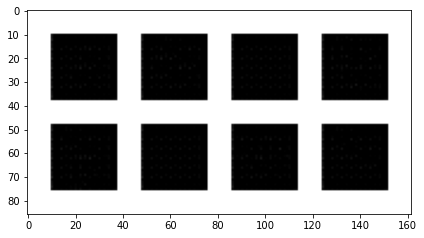

In [34]:
show_batch(a.imgs)

### Instantiate the model, optimizer and scheduler

In [35]:
#vae = CompositionalVae(config)
optimizer = instantiate_optimizer(model=vae, config_optimizer=config["optimizer"])

if config["simulation"]["type"] == "scratch":
    
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 999999

elif config["simulation"]["type"] == "resume":

    if torch.cuda.is_available():
        ckpt = file2ckpt(path="ckpt.pt", device=None)
    else:
        ckpt = file2ckpt(path="ckpt.pt", device='cpu')

    load_from_ckpt(ckpt=ckpt,
                   model=vae,
                   optimizer=optimizer,
                   overwrite_member_var=True)

    epoch_restart = ckpt.get('epoch', -1)
    history_dict = ckpt.get('history_dict', {})
    try:
        min_test_loss = min(history_dict.get("test_loss", 999999))
    except:
        min_test_loss = 999999

elif config["simulation"]["type"] == "pretrained":

    if torch.cuda.is_available():
        ckpt = file2ckpt(path="ckpt.pt", device=None)
    else:
        ckpt = file2ckpt(path="ckpt.pt", device='cpu')

    load_from_ckpt(ckpt=ckpt,
                   model=vae,
                   optimizer=None,
                   overwrite_member_var=False)
       
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 999999
    
else:
    raise Exception("simulation type is NOT recognized")
    
# instantiate the scheduler if necessary    
if config["scheduler"]["is_active"]:
    scheduler = instantiate_scheduler(optimizer=optimizer, config_scheduler=config["scheduler"])
else:
    scheduler = None

### Training loop

In [36]:
TEST_FREQUENCY = config["simulation"]["TEST_FREQUENCY"]
CHECKPOINT_FREQUENCY = config["simulation"]["CHECKPOINT_FREQUENCY"]
NUM_EPOCHS = config["simulation"]["MAX_EPOCHS"]

for epoch in range(1,NUM_EPOCHS+1):
    
    
    vae.train()
    train_metrics = process_one_epoch(model=vae,
                                      dataloader=train_loader,
                                      optimizer=optimizer,
                                      scheduler=scheduler,
                                      iom_threshold=config["architecture"]["nms_threshold_train"],
                                      verbose=(epoch == 0))
    
    with torch.no_grad():
        print("Train " + train_metrics.pretty_print(epoch))
        history_dict = append_to_dict(source=train_metrics,
                                      destination=history_dict,
                                      prefix_exclude="wrong_examples",
                                      prefix_to_add="train_")
        
        if (epoch % TEST_FREQUENCY) == 0:
            vae.eval()
            test_metrics = process_one_epoch(model=vae,
                                             dataloader=test_loader,
                                             optimizer=optimizer,
                                             scheduler=scheduler,
                                             iom_threshold=config["architecture"]["nms_threshold_test"],
                                             verbose=(epoch == 0))
            print("Test  "+test_metrics.pretty_print(epoch))
            history_dict = append_to_dict(source=test_metrics,
                                          destination=history_dict,
                                          prefix_exclude="wrong_examples",
                                          prefix_to_add="test_")
            
        #if (epoch % CHECKPOINT_FREQUENCY == 0) and (epoch >= 20):
        #    ckpt = vae.create_ckpt(optimizer=optimizer,
        #                           epoch=epoch,
        #                           history_dict=history_dict)
        #    ckpt2file(ckpt=ckpt, path="last_ckpt_"+str(epoch))

Train [epoch    1] loss=0.368, mse=0.093, codebook=0.220, commitment=0.220
Train [epoch    2] loss=0.168, mse=0.085, codebook=0.067, commitment=0.067
Train [epoch    3] loss=0.143, mse=0.082, codebook=0.049, commitment=0.049
Train [epoch    4] loss=0.142, mse=0.081, codebook=0.049, commitment=0.049
Train [epoch    5] loss=0.157, mse=0.081, codebook=0.061, commitment=0.061
Test  [epoch    5] loss=0.171, mse=0.082, codebook=0.071, commitment=0.071
Train [epoch    6] loss=0.177, mse=0.080, codebook=0.078, commitment=0.078
Train [epoch    7] loss=0.169, mse=0.059, codebook=0.088, commitment=0.088
Train [epoch    8] loss=0.141, mse=0.043, codebook=0.079, commitment=0.079
Train [epoch    9] loss=0.130, mse=0.036, codebook=0.075, commitment=0.075
Train [epoch   10] loss=0.131, mse=0.033, codebook=0.079, commitment=0.079
Test  [epoch   10] loss=0.131, mse=0.031, codebook=0.080, commitment=0.080
Train [epoch   11] loss=0.126, mse=0.030, codebook=0.077, commitment=0.077
Train [epoch   12] loss=0

KeyboardInterrupt: 

In [37]:
output = vae(img)

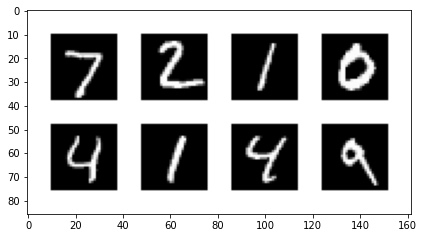

In [38]:
show_batch(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


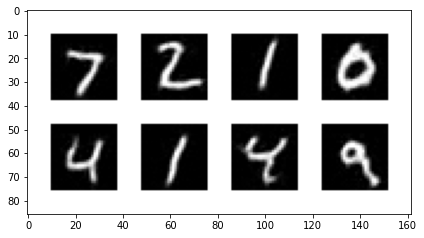

In [39]:
show_batch(output.imgs)

In [40]:
output.inference.index.shape

torch.Size([8, 1, 7, 7])

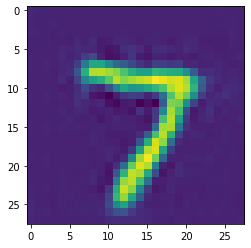

In [41]:
plt.imshow(output.imgs[0,0].detach().cpu())

In [42]:
output.inference.index[0,0]

tensor([[ 87,  87,  87,  87,  87,  87,  87],
        [ 87,  87,  87,  87,  87,  87,  87],
        [ 87,  87,  70, 228, 228, 228,  87],
        [ 87,  87,  87,  18,  87,  65,  87],
        [ 87,  87,  87,  18,  70,  87,  87],
        [ 87,  87,  18,  70,  65,  87,  87],
        [ 87,  87,  87,  70,  87,  87,  87]], device='cuda:0')

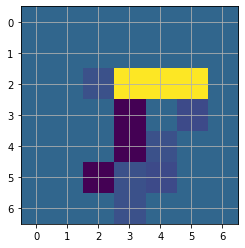

In [43]:
plt.imshow(output.inference.index[0,0].cpu())
plt.grid()

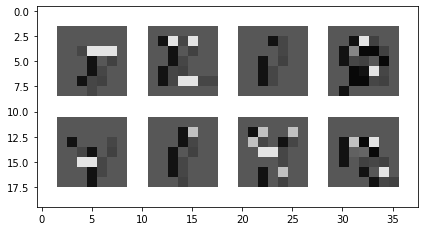

In [51]:
show_batch(output.inference.index, n_padding=2, pad_value=255)

### Visualize the results (for example MSE)

In [ ]:
plt.imshow()